# Usage of processing

Please read [README.md](../README.md) in advance.

## Data Processing

Data Processing means here a conversion from a (tabular) raw data to a feature matrix. This step contains **at least** following tasks.

1. check the quality of data
   - How much is it filled? (NA string? missing rate?)
   - Is the data valid? (Unexpected value in a column?)
   - Is there anything strange/special?
2. understand the data
   - What does each field look like?
   - Is there any pair of two correlated fields?
   - Is a feature variable informative for a prediction?
3. convert the given data into a suitable tabular format (feature matrix)
   - How do we deal with missing values?
   - How do we deal with date and time?
   - What is a meaningful feature matrix for your prediction?

Even though the analysis largely depends on the data set itself, many tasks can be modularized, so that we can avoid to modify your copy-and-pasted chunks to your data set.

In [1]:
from datetime import datetime, timedelta, timezone
import pytz

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.display import display, HTML
plt.style.use("fivethirtyeight")

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6 ## width, height (inches)

#pd.set_option('display.max_rows', None)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
try:
    from adhoc.utilities import fetch_adult_dataset
except ImportError:
    import sys
    sys.path.append("..")
    from adhoc.utilities import fetch_adult_dataset

As a sample dataset we use [Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult). You should consult the linked page for a brief explanation about the fields. The following code downloads the data file and stores it as `../data/adult.csv` (if you have not downloaded it).

In [5]:
from pathlib import Path

csv_path = Path("../data/adult.csv")
fetch_adult_dataset(csv_path)

In [6]:
df = pd.read_csv(str(csv_path))

## dummy variable in datetime 
np.random.seed(51)

base_day = datetime(year=2019, month=4, day=1, tzinfo=pytz.timezone("UTC"))
df["dummy_ts"] = [base_day + timedelta(days=d) for d in 
                  np.random.normal(loc=0, scale=30, size=df.shape[0])]
df["dummy_ts"][0] = np.nan
df["dummy_ym"] = df["dummy_ts"].apply(lambda ts: ts.date().replace(day=1))

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label,dummy_ts,dummy_ym
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,NaT,NaT
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,2019-04-04 08:43:55.897985+00:00,2019-04-01
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2019-05-08 12:34:20.958308+00:00,2019-05-01
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,2019-02-19 04:09:33.194851+00:00,2019-02-01
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,2019-04-03 23:57:06.030944+00:00,2019-04-01


### 1. Check the quality of data

Creating an instance of `Inspector`, you can get an overview of the data quality of your dataset.

In [7]:
from adhoc.processing import Inspector

inspector = Inspector(df, m_cats=20)
inspector

,dtype,count_na,rate_na,n_unique,distinct,variable,sample_value
age,int64,0,0.000000,73,False,continuous,74
workclass,object,1836,0.056386,8,False,categorical,Without-pay
fnlwgt,int64,0,0.000000,21648,False,continuous,206535
education,object,0,0.000000,16,False,categorical,11th
education-num,int64,0,0.000000,16,False,categorical,7
marital-status,object,0,0.000000,7,False,categorical,Never-married
occupation,object,1843,0.056601,14,False,categorical,Sales
relationship,object,0,0.000000,6,False,categorical,Wife
race,object,0,0.000000,5,False,categorical,White
sex,object,0,0.000000,2,False,binary,Female


First of all the instance `inspector` is **not a DataFrame**. The default representation of the instance is the result of the inspection of the given DataFrame. You can access the DataFrame by the property `inspector.result`.

In [8]:
inspector.result.query("count_na > 0")

,dtype,count_na,rate_na,n_unique,distinct,variable,sample_value
workclass,object,1836,0.056386,8,False,categorical,Without-pay
occupation,object,1843,0.056601,14,False,categorical,Sales
native-country,object,583,0.017905,41,False,categorical,Iran
dummy_ts,"datetime64[ns, UTC]",1,0.000031,32560,False,continuous,2019-04-04 16:30:09.483216+00:00
dummy_ym,object,1,0.000031,9,False,categorical,2019-02-01


#### Description of fields of `inspector.result`

- dtype: This is the result of `df.dtypes`
- count_na: The number of missing values (NA) in the column. `df.isna().sum()`
- rate_na: The number of missing values (NA) in the column. `df.isna().mean()`
- n_unique: The number of distinct values in the column. **We ignore missing values here.**
- distinct: If a different row has a different number, then `True` else `False`. When it is `True`, then the column can be an ID such as a primary key or just a continuous variable.
- variable: See below
- sample_value: a randomly picked value. Note that we sample a value for all columns, not a row.

As a basic policy we do not regard a missing value as a valid one, even though the missing value has a special meaning. This policy affects detection of variable types.

#### Types of variables

There are four kinds of types of variables.

1. `constant`: `n_unique==1`.
2. `binary`: it can take only two values. `n_unique==2`
3. `categorical`: it can take finite number of values. `dtype = "object"` or `n_unique <= m_cats`
4. `continuous`: it can take values in real numbers or timestamps.

Remarks:

- We do not care if there is an ordering of values: A nominal variable and an ordinal variable are both just a categorical variable. 
- We regard a binary variable as a special case of a categorical variable.
- A constant variable is neither categorical nor continuous.
- The data type `datetime` is always regarded as a continuous variable, even though it can actually be a categorical variable (such as year-month).

If you want to change the result, you can modify `m_cats` or use `regard_as_categorical()` or `regard_as_continuous()`.

In [9]:
inspector.regard_as_categorical("age")
inspector.result.loc["age",:] ## The variable type of age is categorical

dtype                 int64
count_na                  0
rate_na                   0
n_unique                 73
distinct              False
variable        categorical
sample_value             74
Name: age, dtype: object

If we assign a number to `m_cats`, then the inspection is computed again. As a result your manual modification of variable types will be lost.

In [10]:
inspector.m_cats = 20
inspector.result.query("dtype == 'int64'") ## The variable type of age is now continuous.

,dtype,count_na,rate_na,n_unique,distinct,variable,sample_value
age,int64,0,0.0,73,False,continuous,74
fnlwgt,int64,0,0.0,21648,False,continuous,206535
education-num,int64,0,0.0,16,False,categorical,7
capital-gain,int64,0,0.0,119,False,continuous,2176
capital-loss,int64,0,0.0,92,False,continuous,2002
hours-per-week,int64,0,0.0,94,False,continuous,7


If you want to calculate the inspection once again because you converted a column, then `make_an_inspection()` does the job.

In [11]:
inspector.make_an_inspection()

,dtype,count_na,rate_na,n_unique,distinct,variable,sample_value
age,int64,0,0.000000,73,False,continuous,37
workclass,object,1836,0.056386,8,False,categorical,Never-worked
fnlwgt,int64,0,0.000000,21648,False,continuous,100154
education,object,0,0.000000,16,False,categorical,Doctorate
education-num,int64,0,0.000000,16,False,categorical,3
marital-status,object,0,0.000000,7,False,categorical,Never-married
occupation,object,1843,0.056601,14,False,categorical,Transport-moving
relationship,object,0,0.000000,6,False,categorical,Husband
race,object,0,0.000000,5,False,categorical,Other
sex,object,0,0.000000,2,False,binary,Male


We can get easily the list of categorical/continuous variables. (Note that a constant variable is neither categorical nor continuous.)

In [12]:
print(inspector.get_cats()) ## list of categorical variables (binary or categorical)

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'label', 'dummy_ym']


In [13]:
print(inspector.get_cons()) ## list of continuous variables 

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'dummy_ts']


#### Distributions 

In order to find a special/strange values we need to check the distributions of the variables. 

The distributions of categorical variables is shown by `distribution_cats()`

In [14]:
inspector.distribution_cats(fields=["workclass","dummy_ym"], sort=True)

count      rate
field     value                               
workclass Private              22696  0.697030
          Self-emp-not-inc      2541  0.078038
          Local-gov             2093  0.064279
          State-gov             1298  0.039864
          Self-emp-inc          1116  0.034274
          Federal-gov            960  0.029483
          Without-pay             14  0.000430
          Never-worked             7  0.000215
dummy_ym  2019-03-01 00:00:00  11461  0.351986
          2019-04-01 00:00:00  11134  0.341943
          2019-05-01 00:00:00   4440  0.136359
          2019-02-01 00:00:00   3968  0.121864
          2019-01-01 00:00:00    814  0.024999
          2019-06-01 00:00:00    673  0.020669
          2018-12-01 00:00:00     35  0.001075
          2019-07-01 00:00:00     34  0.001044
          2019-08-01 00:00:00      1  0.000031

If `fields` is not given, then the distributions of all categorical variables are shown.

You can also give selected fields to see their distribution in the above form. You can also give a continuous variable.

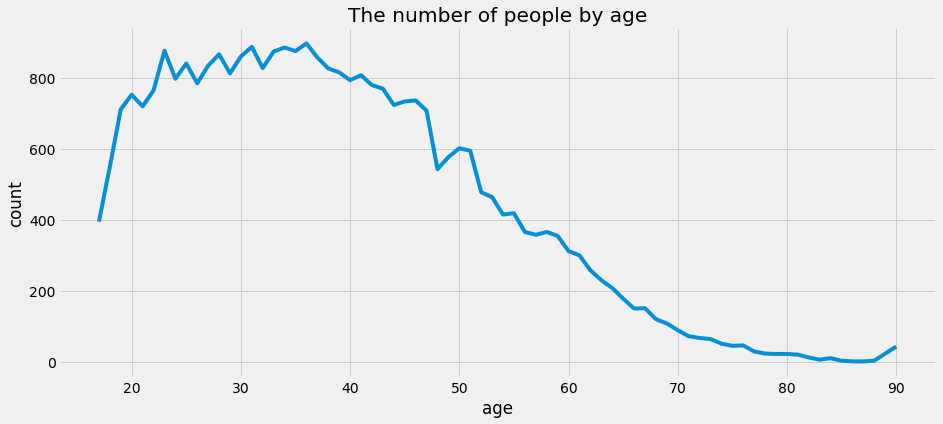

In [15]:
## Obviously a histogram is better and easier than this, but this is just an example.
inspector.distribution_cats(["age"]).reset_index(level=0)["count"].plot()
plt.xlabel("age")
plt.ylabel("count")
plt.title("The number of people by age");

On the other hand, `distribution_cons()` shows just the same information as `df[inspector.get_cons()].describe().T`.

In [16]:
inspector.distribution_cons()

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


Note that there is no statistics about `dummy_ts`. This is because the units of statistics are not unique. (e.g. `min` is time and `std` is duration.) `distribution_timestamps()` computes the statistics for such columns.

In [17]:
inspector.distribution_timestamps()

,count,mean,std,min,25%,50%,75%,max
dummy_ts,32560,2019-04-01 01:22:26.233419088+00:00,30 days 00:06:54.614820,2018-12-09 19:38:35.295731+00:00,2019-03-11 19:03:59.804376750+00:00,2019-04-01 00:03:44.645501+00:00,2019-04-21 14:39:42.926995+00:00,2019-08-05 03:25:59.116850+00:00


Since `date` is recognized as an "object", `distribution_timestamps()` ignores `dummy_ym`, but you can compute the same statistics by giving the column name explicitly.

In [18]:
inspector.distribution_timestamps(fields=["dummy_ym"])

,count,mean,std,min,25%,50%,75%,max
dummy_ym,32560,2019-03-16 23:14:29.484029484+00:00,31 days 00:59:11.537434,2018-12-01 00:00:00+00:00,2019-03-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,2019-08-01 00:00:00+00:00


## 2. Understand the data

It is most important to understand the meaning of each field. This must be the first step before analyzing the data. But it is not always the case that you can get a useful information about the fields. For examples the following explanation come from the data set description.

> education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
> 
> education-num: continuous.

What is `education-num`? What is the relation between them? The answer can be easily found by looing at the crosstab of two fields.

In [19]:
pd.crosstab(df["education"],df["education-num"])

education-num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,933,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1175,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0
1st-4th,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,646,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,514,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1067,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1382,0,0,0,0,0


Namely `education-num` is just an alias of `education`. So we should remove one of them. In other words,

1. delete `education-num` and use `education` as a nominal variable. Or
2. delete `education` and use `education-num` as an ordinal variable.

The default option would be 1, because the education level is not (linearly) "ordered".

Next, what is the relation between `capital-gain` and `capital-loss`? Let us see the scatter plot of these two variables.

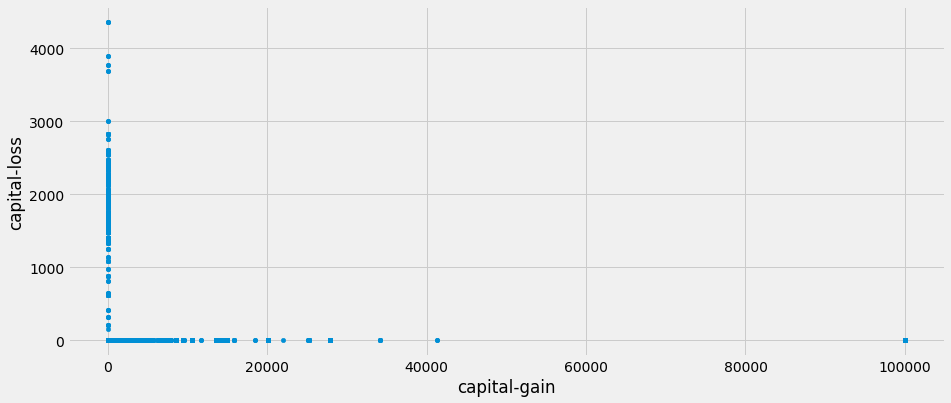

In [20]:
df.plot.scatter(x="capital-gain",y="capital-loss");

It is easy to guess that one of the variables takes nonzero, then another is zero. 

In [21]:
(df["capital-gain"]*df["capital-loss"]).abs().sum() ## abs() is actually redundant.

0

So why do we have two fields? They must be merged in one field, mustn't they?

Or there must be a (relatively) clear relation between `workclass` and `label`. Looking at the crosstab of the two fields, we can find that `Never-worked` and `Without-pay` imply "low income". This is obvious, but important to check.

In [22]:
pd.crosstab(df["workclass"],df["label"])

label,<=50K,>50K
workclass,,
Federal-gov,589,371
Local-gov,1476,617
Never-worked,7,0
Private,17733,4963
Self-emp-inc,494,622
Self-emp-not-inc,1817,724
State-gov,945,353
Without-pay,14,0


Anyway, it is very important to see the relation between two fields, because it is part of understanding data.

|feature\target|categorical|continuous|
|-|-|-|
|categorical|Bar chart or heatmap|violine|
|continuous|KDE or histogram|joint plot|

#### categorical vs categorical

The following bar chart shows the distributions of workclass by label. That is the sum of the (length/area of) blue/red bar is 1.

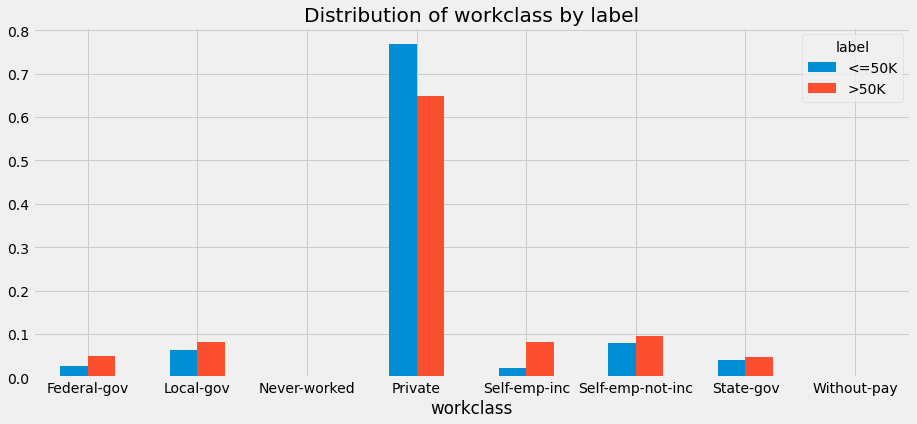

In [23]:
inspector.visualize_two_fields("workclass","label")

We can show the same information by using heatmap. Since we compute the distribution of the `workclass` by `label`, the sum of each row in the heat map is 1.

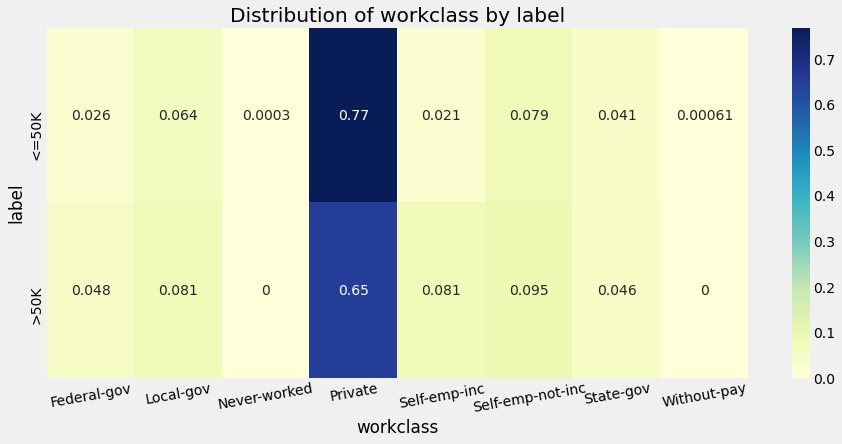

In [24]:
inspector.visualize_two_fields("workclass","label", heatmap=True, rotation=10)

If one or both categorical fields can take lots of values, then it is better to use just a crosstab or its heatmap. A visualization is not always the best solution.

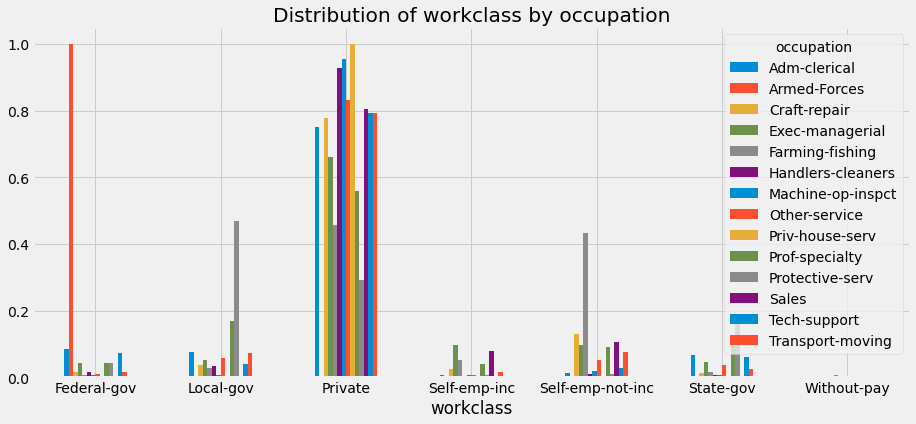

In [25]:
inspector.visualize_two_fields("workclass","occupation")

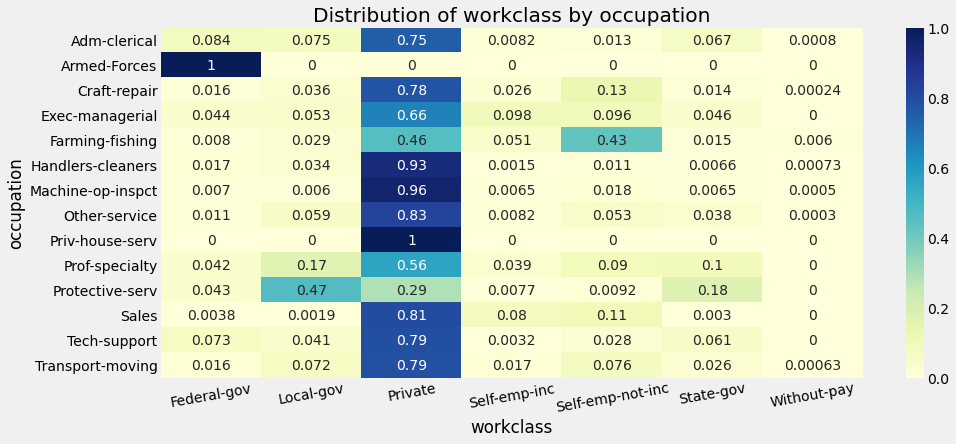

In [26]:
inspector.visualize_two_fields("workclass","occupation", heatmap=True, rotation=10)

#### categorical vs continuous

The most popular visualization for this situation is probably a boxplot. But the whiskers are awkward to explain (to people who are not familiar with it).

The violine plot does a similar job. This is just a visualisation of KDE. In my opinion, the violine plot is better than the box-and-whisker plot.

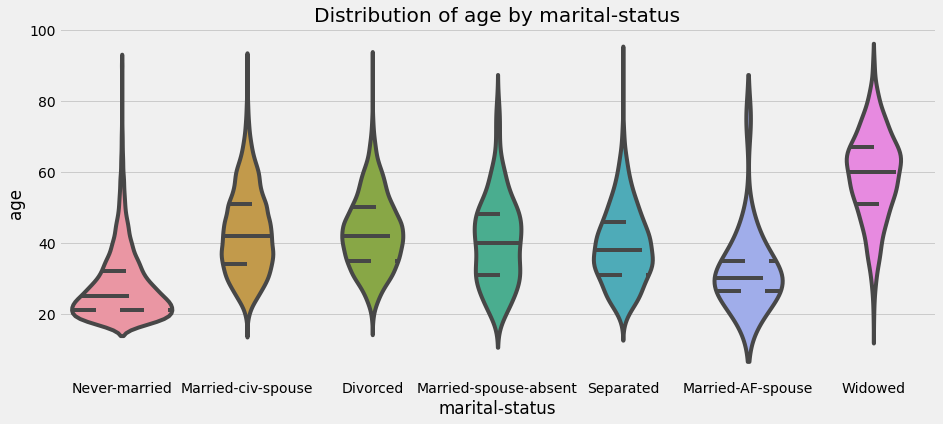

In [27]:
inspector.visualize_two_fields("marital-status", "age")

#### continuous vs categorical

This is quite similar to "categorical vs continuous". The difference is just the types of variables for the axes.






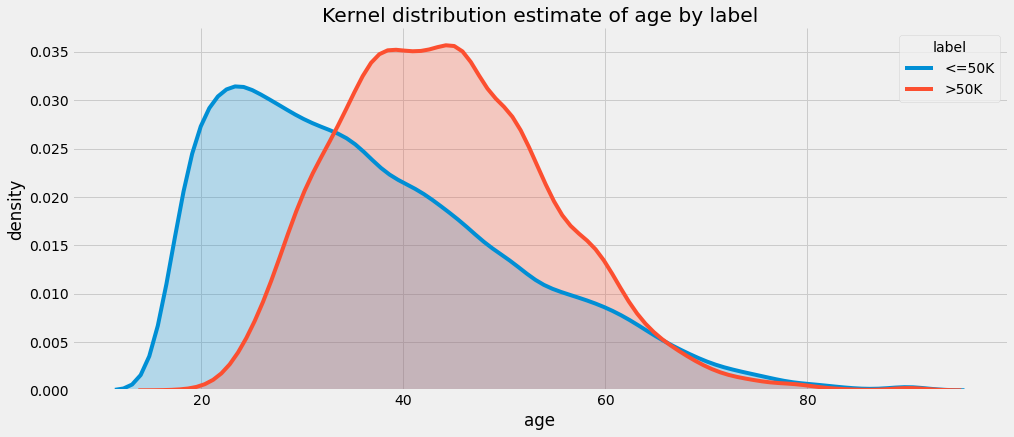

In [28]:
inspector.visualize_two_fields("age","label") ## con vs cat

#### continuous vs continuous

For the comparison between continuous variables `seaborn` provides a good visualization function: `pairplot`. This function also accepts an additional categorical variable as "hue". 

In [29]:
inspector.get_cons()

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'dummy_ts']

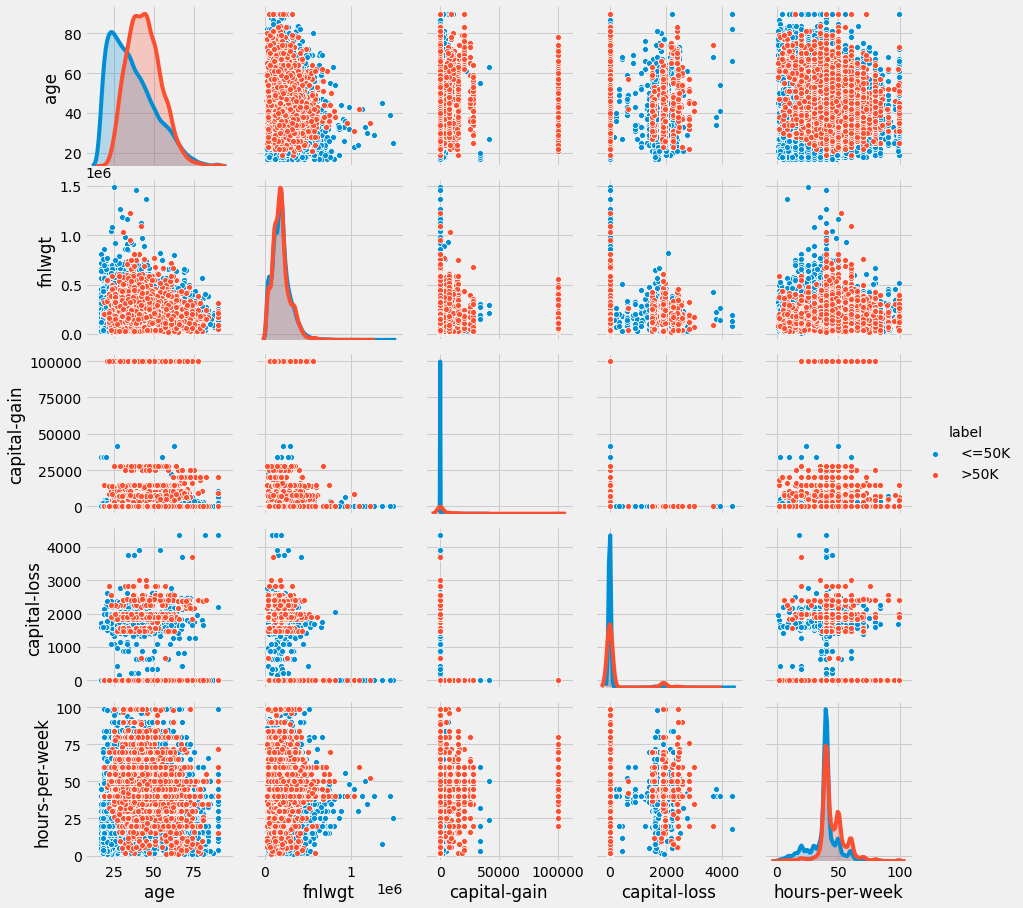

In [30]:
sns.pairplot(df, vars=inspector.get_cons()[:-1], hue="label");

Here we do not have "dummy_ts" in the diagram again. The original reason is that `seaborn` (or `matplotlib`) does not support datetime in an expected way. (The following `jointplot` raises an exception and does not show histograms.)

float() argument must be a string or a number, not 'Timestamp'


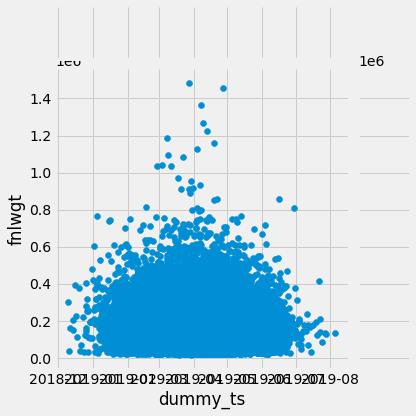

In [31]:
try:
    sns.jointplot(x="dummy_ts", y="fnlwgt", data=df.dropna(how="any"))
except TypeError as e:
    print(e)
else:
    print("without error!")
finally:
    plt.xticks(rotation=90)

If you want to draw time series (line plot), then `pandas.Series.plot` or `sns.tsplot` does the job.

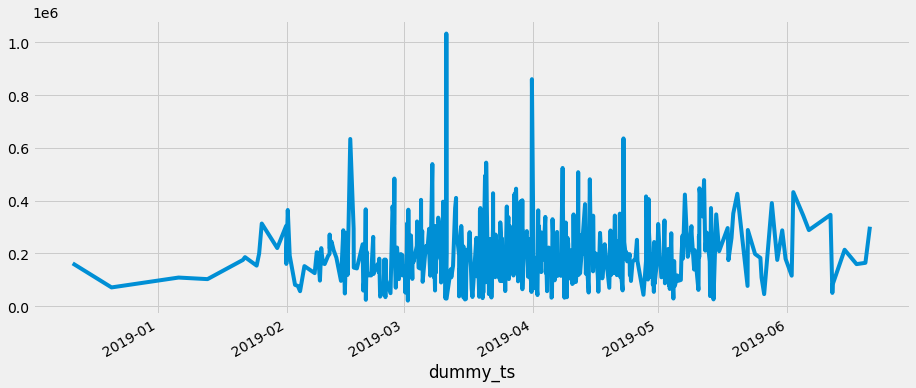

In [32]:
x = df[["dummy_ts","fnlwgt"]].dropna(how="any").head(500).set_index("dummy_ts")["fnlwgt"]
x = x.sort_index()
x.plot();

But it is more important to think about whether the scatter plot of (datetime, value) helps us understand data. Probably you need to aggregate the data by hour/day/month. 

We should not forget a correlation heatmap. 

In [33]:
df.corr(method="spearman")

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.078141,0.066345,0.124948,0.058484,0.142907
fnlwgt,-0.078141,1.000000,-0.035706,-0.006039,-0.006914,-0.021621
education-num,0.066345,-0.035706,1.000000,0.119140,0.074749,0.167215
capital-gain,0.124948,-0.006039,0.119140,1.000000,-0.066569,0.093322
capital-loss,0.058484,-0.006914,0.074749,-0.066569,1.000000,0.059852
hours-per-week,0.142907,-0.021621,0.167215,0.093322,0.059852,1.000000


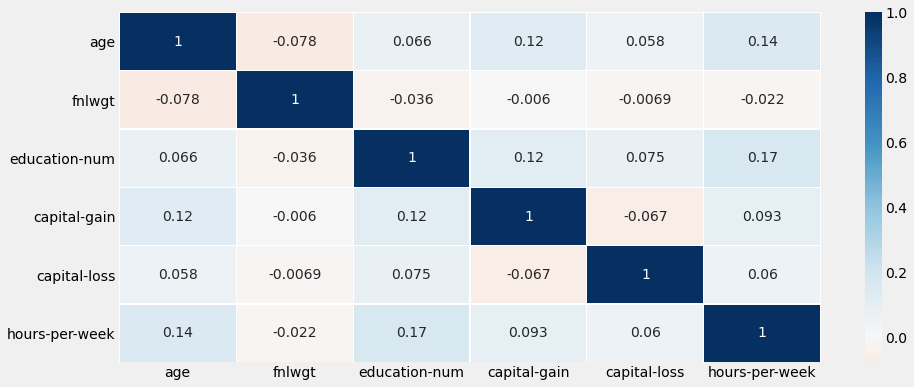

In [34]:
sns.heatmap(df.corr(method="spearman"), annot=True, linewidths=0.1, center=0, cmap="RdBu");

Our module provides a short cut to the joint plot of two continuous variables.

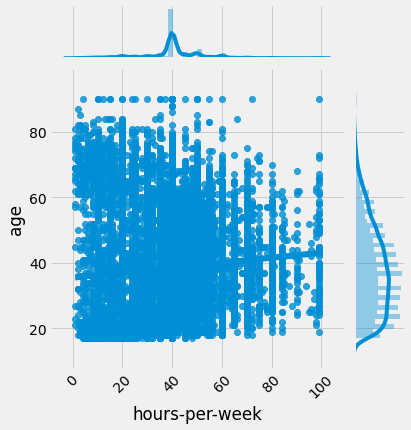

In [35]:
inspector.visualize_two_fields("hours-per-week", "age", rotation=45)

#### Statistical test 

The diagramms are very helpful to understand the relation between fields and to get some insights. But It might be difficult to make a decision by looking only at diagramms: Is the field useful for making a prediction?

In such a case we may execute statistical tests.

|feature\target|categorical|continuous|
|-|-|-|
|categorical|$\chi^2$-test|ANOVA|
|continuous|ANOVA|correlation|

**Remark**

1. It is usual that the p-values you got are extremly small. In particular when you have a relatively large dataset.
2. The null-hypotheses of the tests are quite different.
   - $\chi^2$-test : two categorical variables are independent.
   - one-way ANOVA on ranks: consider the groups by the value of the categorical variable. Then the null-hypothesis is that the medians of the continuous variable in the groups are the same.
   - Correlation: The two continuous variables are not correlated. 
3. The result of chi-square test for `dummy_ts` is shown. We have to think of whether it is meaningful.

In [36]:
inspector.significance_test_features("label", verbose=False)

,field1,field2,test,statistic,pval
0,age,label,one-way ANOVA on ranks,2425.99,0
1,workclass,label,chi-square test,827.718,1.93385e-174
2,fnlwgt,label,one-way ANOVA on ranks,3.75398,0.0526819
3,education,label,chi-square test,4429.65,0
4,education-num,label,chi-square test,4429.65,0
5,marital-status,label,chi-square test,6517.74,0
6,occupation,label,chi-square test,3744.9,0
7,relationship,label,chi-square test,6699.08,0
8,race,label,chi-square test,330.92,2.30596e-70
9,sex,label,chi-square test,1517.81,0


According to the above table the p-value of the ANOVA for `fnlwgt` and `label` is relatively large. In fact the KDE of `flnwgt` by `label` are quite similar.

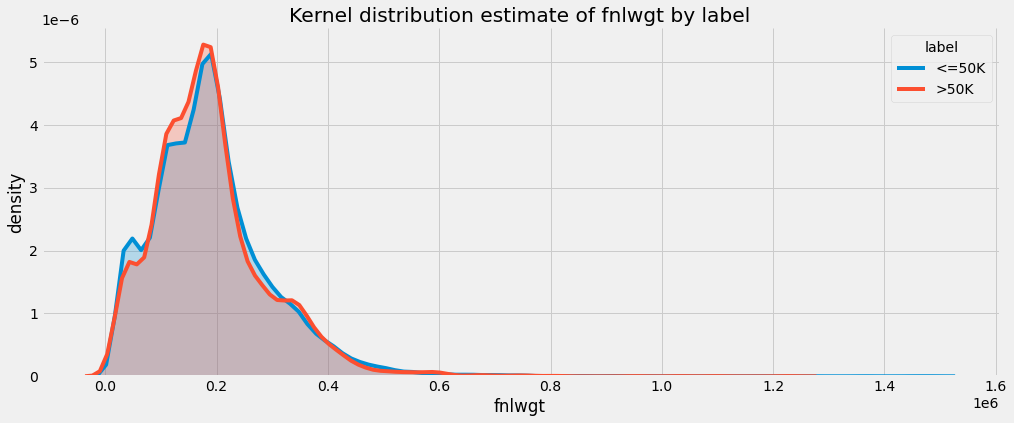

In [37]:
inspector.visualize_two_fields("fnlwgt", "label")  ## con vs cat

## 3. Convert the DataFrame into a feature matrix

1. Fill missing values with the most-frequent value.
2. Apply a one-hot-encoder to each categorical variable.

These two steps can be combined to one step by chosing some classes. If we just apply a one-hot-encoder to a categorical variable without missing values, then the feature matrix (including a constant column) has a colinear tuple of columns. The existance of linearly dependent variables is harmful when we train a linear model.

In [38]:
df["capital-gain"] = df["capital-gain"] - df["capital-loss"] ## merge the two fields

In [39]:
df.drop(["education-num","capital-loss","dummy_ym","dummy_ts"], axis=1, inplace=True)
inspector.make_an_inspection() ## update the inspection

,dtype,count_na,rate_na,n_unique,distinct,variable,sample_value
age,int64,0,0.000000,73,False,continuous,44
workclass,object,1836,0.056386,8,False,categorical,Self-emp-inc
fnlwgt,int64,0,0.000000,21648,False,continuous,39615
education,object,0,0.000000,16,False,categorical,Assoc-voc
marital-status,object,0,0.000000,7,False,categorical,Separated
occupation,object,1843,0.056601,14,False,categorical,Other-service
relationship,object,0,0.000000,6,False,categorical,Husband
race,object,0,0.000000,5,False,categorical,Asian-Pac-Islander
sex,object,0,0.000000,2,False,binary,Female
capital-gain,int64,0,0.000000,210,False,continuous,-2238


#### Fill missing values and one-hot encoding

There are *at least* two steps to convert the DataFrame into a feature matrix:

1. Fill missing values
2. Convert a categorical variable into numerical column(s).

##### 1. Fill missing values

First of all if a missing value has a special meaning, then we should fill them manually. But it is usual that missing values still remain after this step. In such a case we have to fill them by applying [a specific strategy](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). 

##### 2. Convert a categorical variable into numerical column(s)

We can not apply a machine learning model to a matrix with non numerical values. Most easiest way to achieve this is one-hot encoding. Assume that a categorical variable has $k$ classes. Then the original column (with $n$ instances) will be converted into an $n \times k$-matrix. Each column corresponds to a single class.

An example is following. The first column is the "original" values and the rest 5 columns is the result of one-hot encoding.

In [40]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(df["race"])

pd.concat([df["race"],
           pd.DataFrame(lb.transform(df["race"]), 
                        index=df.index, columns=lb.classes_)],
          axis=1).drop_duplicates()

,race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,White,0,0,0,0,1
3,Black,0,0,1,0,0
11,Asian-Pac-Islander,0,1,0,0,0
15,Amer-Indian-Eskimo,1,0,0,0,0
50,Other,0,0,0,1,0


The problem of one-hot encoding is that the feature matrix is always collinear you apply one-hot encoding to multiple columns. The collinearity causes a problem if we train a linear model: Training is very unstable. 

Here is an illustrative example: A linear regression model predicting `age` by using two features `workclass` and `marital-status`. As you see the regression coefficients are too large/small. Even though the trained model can produce predictions in a reasonable range, the coefficients are not explainable.

In [41]:
from sklearn.linear_model import LinearRegression

df_tmp = df[["workclass","marital-status","age"]].dropna(how="any")

lb0 = LabelBinarizer().fit(df_tmp["workclass"])
lb1 = LabelBinarizer().fit(df_tmp["marital-status"])

X = np.concatenate([lb0.transform(df_tmp["workclass"]),
                    lb1.transform(df_tmp["marital-status"])],
                    axis=1)
y = df_tmp["age"]

lr = LinearRegression()
lr.fit(X,y)
s_coef = pd.Series(lr.coef_, index=list(lb0.classes_)+list(lb1.classes_), name="coef")
s_coef["intercept"] = lr.intercept_
s_coef

Federal-gov             -1.353170e+13
Local-gov               -1.353170e+13
Never-worked            -1.353170e+13
Private                 -1.353170e+13
Self-emp-inc            -1.353170e+13
Self-emp-not-inc        -1.353170e+13
State-gov               -1.353170e+13
Without-pay             -1.353170e+13
Divorced                -2.834432e+13
Married-AF-spouse       -2.834432e+13
Married-civ-spouse      -2.834432e+13
Married-spouse-absent   -2.834432e+13
Never-married           -2.834432e+13
Separated               -2.834432e+13
Widowed                 -2.834432e+13
intercept                4.187602e+13
Name: coef, dtype: float64

If we drop one of the classes (a.k.a. dummy variable) for each categorical variable, then we obtain explainable coefficients:

In [42]:
from sklearn.linear_model import LinearRegression

df_tmp = df[["workclass","marital-status","age"]].dropna(how="any")

lb0 = LabelBinarizer().fit(df_tmp["workclass"])
lb1 = LabelBinarizer().fit(df_tmp["marital-status"])

X = np.concatenate([lb0.transform(df_tmp["workclass"])[:,1:],
                    lb1.transform(df_tmp["marital-status"])[:,1:]],
                    axis=1)
y = df_tmp["age"]

lr = LinearRegression()
lr.fit(X,y)
s_coef = pd.Series(lr.coef_, index=list(lb0.classes_)[1:]+list(lb1.classes_)[1:], name="coef")
s_coef["intercept"] = lr.intercept_
s_coef

Local-gov                -0.952331
Never-worked            -15.357259
Private                  -4.181003
Self-emp-inc              1.631631
Self-emp-not-inc          1.218562
State-gov                -2.040144
Without-pay               5.191494
Married-AF-spouse       -12.391344
Married-civ-spouse       -0.507244
Married-spouse-absent    -2.477538
Never-married           -14.034141
Separated                -3.177797
Widowed                  14.633620
intercept                46.025537
Name: coef, dtype: float64

Theoretically no information will be lost, even though one of the classes is dropped.

Class `MultiConverter` does the two steps at the same time. 

In [43]:
from adhoc.processing import MultiConverter

cats = inspector.get_cats() ## variables for which LabelBinarizer is applied.
strategy = {cat:"most_frequent" for cat in cats} ## 

converter = MultiConverter(columns=df.columns, cats=cats, strategy=strategy)
converter.fit(df)

pd.DataFrame(converter.transform(df), columns=converter.classes_).head()

,age,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,fnlwgt,education_10th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_Vietnam,native-country_Yugoslavia,label_>50K
0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,77516.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,83311.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215646.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234721.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,338409.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Consult the docstring for the usage of the class. Here is an overview of this transformation.

1. Apply `SimpleImputer` for all columns. The strategy of the imputation can be given through the `strategy` argument. **You should give strategies for all categorical variables**, because the default value of `strategy` is `mean` and this is nonsense for categorical variables. See the previous code chunk.
2. If `strategy` is not `most_frequent`, `mean` or `median`, then we fill the missing values with the given value.
3. We apply one-hot encoder for all categorical variables. As default the dummy variable corresponding to the most frequent class will be removed. 
4. You can give manually a dropping class to `drop` argument. But this is ignored if the categorical variable is binary.
5. `converter.classes_` gives you the original variable name and the corresponding class names.
6. `fit_transform()` is available. But you should not include this instance in `sklearn.pipeline.Pipeline` unless you specifies dropping values for all categorical variable. This is because the dropping variable can change during cross-validation.

In [44]:
df_transformed = pd.DataFrame(converter.transform(df), columns=converter.classes_)
df_transformed.to_pickle("../data/feature_matrix.pkl")

## Environment

In [45]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas,matplotlib,seaborn

Sun Jul 05 2020 

CPython 3.7.0
IPython 7.16.1

numpy 1.18.0
scipy 1.5.0
sklearn 0.23.1
pandas 1.0.5
matplotlib 3.2.2
seaborn 0.10.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.12.14-lp151.28.52-default
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
